In [81]:
import tensorflow as tf
import unicodedata
import string
import numpy as np
import re
import matplotlib.pyplot as plt
from google.colab import drive

In [82]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [83]:
keras = tf.keras
print(tf.__version__)

2.5.0


In [84]:
SOS_token = 0
EOS_token = 1

In [85]:
class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2int = {}
        self.word2count = {}
        self.int2word = {0 : "SOS", 1 : "EOS"}
        self.n_words = 2
        
    def addWord(self, word):
        if word not in self.word2int:
            self.word2int[word] = self.n_words
            self.word2count[word] = 1
            self.int2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

In [86]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) \
                   if unicodedata.category(c) != "Mn")

In [87]:
def normalizeString(text):
  text = text.strip()
  text = re.sub("[إأٱآا]", "ا", text)
  text = re.sub("ى", "ي", text)
  text = re.sub("ؤ", "ء", text)
  text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", text)
  noise = re.compile(""" ّ    | # Tashdid
                            َ    | # Fatha
                            ً    | # Tanwin Fath
                            ُ    | # Damma
                            ٌ    | # Tanwin Damm
                            ِ    | # Kasra
                            ٍ    | # Tanwin Kasr
                            ْ    | # Sukun
                            ـ     # Tatwil/Kashida
                        """, re.VERBOSE)
  text = re.sub(noise, '', text)
  text = re.sub(r'(.)\1+', r"\1\1", text) 
  
  return text.lower()


In [88]:
def load_dataset():
    with open("/content/gdrive/MyDrive/ar.txt",'r') as f:
        lines = f.readlines()
    
    pairs = [[normalizeString(pair) for pair in 
              line.strip().split('\t')][0:2] for line in lines]
    return pairs

In [89]:
pairs = load_dataset()
pairs[2]

['a box of matches', 'علبه كبريت']

In [90]:
pairs_2 = []
[pairs_2.append(x) for x in pairs if x not in pairs_2]
pairs = pairs_2


In [91]:
pairs[1]


['a block of flats', 'مجموعه شقق سكنيه متلاصقه']

In [92]:
MAX_LENGTH = 10
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

def sentencetoIndexes(sentence, lang):
    indexes = [lang.word2int[word] for word in sentence.split()]
    indexes.append(EOS_token)
    return indexes



In [93]:
def build_lang(lang1, lang2, max_length=10):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    input_seq = []
    output_seq = []
    
    for pair in pairs:
        input_lang.addSentence(pair[1])
        output_lang.addSentence(pair[0])
    for pair in pairs:
        input_seq.append(sentencetoIndexes(pair[1], input_lang))
        output_seq.append(sentencetoIndexes(pair[0], output_lang))
    return keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_length, padding='post',
                                                      truncating='post'), \
keras.preprocessing.sequence.pad_sequences(output_seq, padding='post', truncating='post'),\
input_lang, output_lang

In [94]:
input_tensor, output_tensor, input_lang, output_lang = build_lang('ar', 'en')

In [95]:
print("input_tensor at index 10: {}".format(input_tensor[10]))
print("output_tensor at index 10: {}".format(output_tensor[10]))
print("corresponding integer value for 'انا' {}".format(input_lang.word2int['انا']))
print("corresponding integer value for 'want' {}".format(output_lang.word2int['want']))

input_tensor at index 10: [26 27  1  0  0  0  0  0  0  0]
output_tensor at index 10: [ 2 23  1  0  0  0  0  0  0  0]
corresponding integer value for 'انا' 1918
corresponding integer value for 'want' 3156


In [96]:
BATCH_SIZE = 16
BUFFER_SIZE = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))\
                                                        .shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [97]:
class Encoder(keras.models.Model):
    def __init__(self, vocab_size, num_hidden=256, num_embedding=256, batch_size=16):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.num_embedding = num_embedding
        self.embedding = keras.layers.Embedding(vocab_size, num_embedding)
        self.gru = keras.layers.GRU(num_hidden, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                   return_state=True)
        
    def call(self, x, hidden):
        embedded = self.embedding(x)
        rnn_out, hidden = self.gru(embedded, initial_state=hidden)
        return rnn_out, hidden
    def init_hidden(self):
        return tf.zeros(shape=(self.batch_size, self.num_hidden))

In [98]:
inputs, outputs = next(iter(dataset))
hidden = tf.zeros((16, 256))

In [99]:
encoder = Encoder(input_lang.n_words)

In [100]:
e_outputs, e_hidden = encoder(inputs, hidden)

In [101]:
e_hidden

<tf.Tensor: shape=(16, 256), dtype=float32, numpy=
array([[ 0.01334922, -0.00613109, -0.01270204, ..., -0.01048437,
        -0.00603429, -0.00377161],
       [ 0.01867652, -0.00535181, -0.02266036, ..., -0.01269673,
        -0.00490011, -0.00879866],
       [ 0.0254486 , -0.01196414, -0.02703875, ..., -0.01560366,
        -0.01149636, -0.01401618],
       ...,
       [ 0.02449796, -0.01126191, -0.02690011, ..., -0.01577139,
        -0.01048661, -0.01394613],
       [ 0.0248558 , -0.01136032, -0.02659996, ..., -0.01587146,
        -0.01082783, -0.01405934],
       [ 0.02498071, -0.01171136, -0.02573386, ..., -0.01618567,
        -0.01089381, -0.01451182]], dtype=float32)>

In [102]:
class BahdanauAttention(keras.models.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
    
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, encoder_out, hidden):
        #shape of encoder_out : batch_size, seq_length, hidden_dim 
        #shape of encoder_hidden : batch_size, hidden_dim 
        
        hidden = tf.expand_dims(hidden, axis=1) #out:
        
        score = self.V(tf.nn.tanh(self.W1(encoder_out) + \
                                  self.W2(hidden))) 
        
        attn_weights = tf.nn.softmax(score, axis=1)
        
        context =  attn_weights * encoder_out 
        context = tf.reduce_sum(context, axis=1)
        return context, attn_weights
        

In [103]:
attn = BahdanauAttention(256)

In [104]:
context, attn_weights = attn(e_outputs, e_hidden)

In [105]:
attn_weights.shape

TensorShape([16, 10, 1])

In [106]:
class Decoder(keras.models.Model):
    def __init__(self, vocab_size, dec_dim=256, embedding_dim=256):
        super(Decoder, self).__init__()
        
        self.attn = BahdanauAttention(dec_dim)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(dec_dim, recurrent_initializer='glorot_uniform',
                                   return_sequences=True, return_state=True)
        self.fc = keras.layers.Dense(vocab_size)
        
    def call(self, x, enc_hidden, enc_out):
        x = self.embedding(x)
        context, attn_weights = self.attn(enc_out, enc_hidden)
        x = tf.concat((tf.expand_dims(context, 1), x), -1)
        r_out, hidden = self.gru(x, initial_state=enc_hidden)
        out = tf.reshape(r_out,shape=(-1, r_out.shape[2]))
        return self.fc(out), hidden, attn_weights

In [107]:
decoder = Decoder(output_lang.n_words)

In [108]:
input_tensor, output_tensor = next(iter(dataset))

In [109]:
x = np.expand_dims(output_tensor[:,1], -1)

In [110]:
@tf.function
def loss_fn(real, pred):
    criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    _loss = criterion(real, pred)
    mask = tf.cast(mask, dtype=_loss.dtype)
    _loss *= mask
    return tf.reduce_mean(_loss)

In [111]:
optimizer = tf.optimizers.Adam()

In [112]:
def train_step(input_tensor, target_tensor, enc_hidden):
    loss = 0.0
    with tf.GradientTape() as tape:
    
        batch_size = input_tensor.shape[0]
        enc_output, enc_hidden = encoder(input_tensor, enc_hidden)

        SOS_tensor = np.array([SOS_token])
        dec_input = tf.squeeze(tf.expand_dims([SOS_tensor]*batch_size, 1), -1)
        dec_hidden = enc_hidden

        for tx in range(target_tensor.shape[1]-1):
          
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                            enc_output)
            loss += loss_fn(target_tensor[:, tx], dec_out)
            dec_input = tf.expand_dims(target_tensor[:, tx], 1)

    batch_loss = loss / target_tensor.shape[1]
    t_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, t_variables)
    optimizer.apply_gradients(zip(gradients, t_variables))
    return batch_loss
    

In [113]:
hidden = tf.zeros(shape=(16, 256))
loss = train_step(input_tensor, output_tensor, hidden)
print(loss)

tf.Tensor(5.954051, shape=(), dtype=float32)


In [114]:
def checkpoint(model, name=None):
    if name is not None:
        model.save_weights('/content/gdrive/MyDrive/{}.h5'.format(name))
    else:
        raise NotImplementedError

In [115]:
encoder.load_weights('/content/gdrive/MyDrive/encoder.h5')
decoder.load_weights('/content/gdrive/MyDrive/decoder.h5')

In [116]:
EPOCHS = 10
log_every = 50
steps_per_epoch = len(pairs) // BATCH_SIZE
loss_list = []

for e in range(1, EPOCHS):
    
    total_loss = 0.0
    enc_hidden = encoder.init_hidden()
    
    for idx, (input_tensor, target_tensor) in enumerate(dataset.take\
                                                        (steps_per_epoch)):
        batch_loss = train_step(input_tensor, target_tensor, hidden)
        total_loss += batch_loss
        
        if idx % log_every == 0:
            loss_list.append(batch_loss)
            print("Epochs: {} batch_loss: {:.4f}".format(e, batch_loss))
            checkpoint(encoder, 'encoder')
            checkpoint(decoder, 'decoder')
            
    if e % 1 == 0:
        print("Epochs: {}/{} total_loss: {:.4f}".format(
        e, EPOCHS, total_loss / steps_per_epoch))

Epochs: 1 batch_loss: 0.0375


KeyboardInterrupt: ignored

In [118]:
def translate(sentence, max_length=10):
    result = ''
    attention_plot = np.zeros((10,10))
    sentence = normalizeString(sentence)
    sentence = sentencetoIndexes(sentence, input_lang)
    sentence = keras.preprocessing.sequence.pad_sequences([sentence],\
                                                          padding='post',
                                                      maxlen=max_length,\
                                                       truncating='post')
    
    encoder_hidden = hidden = [tf.zeros((1, 256))]
    
    enc_out, enc_hidden = encoder(sentence, encoder_hidden)
    
    dec_hidden = enc_hidden
    SOS_tensor = np.array([SOS_token])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor], 1), -1)
    
    for tx in range(max_length):
        dec_out, dec_hidden, attn_weights = decoder(dec_input,
                                                   dec_hidden, enc_out)
        attn_weights = tf.reshape(attn_weights, (-1, ))
        attention_plot[tx] = attn_weights.numpy()
        pred = tf.argmax(dec_out, axis=1).numpy()
        result += output_lang.int2word[pred[0]] + " "
        if output_lang.int2word[pred[0]] == "EOS":
            break
        dec_input = tf.expand_dims(pred, axis=1)
    return result, attention_plot

In [119]:
sentence = "هل انت مشغول غداً صباحاً "
pred, attn_weights = translate(sentence)
print(pred)

are you busy tomorrow morning? EOS 


In [120]:
encoder.save_weights('/content/gdrive/MyDrive/encoder.h5')
decoder.save_weights('/content/gdrive/MyDrive/decoder.h5')

In [121]:
def plot_attention(attention, sentence, predicted_sentence):
    #sentence = normalizeString(sentence)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [122]:
from matplotlib import ticker

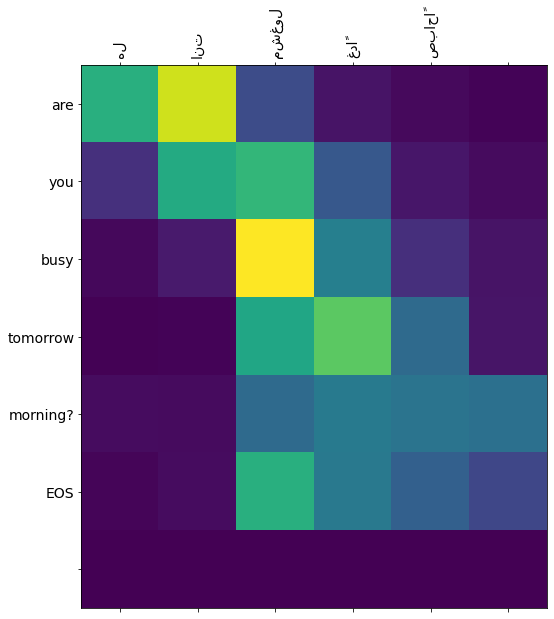

In [123]:
attn_weights = attn_weights[:len(pred.split(' ')), :len(sentence.split(' '))]
plot_attention(attn_weights, sentence.split(), pred.split())

In [ ]:
import anvil.server


In [ ]:
pip install anvil-uplink

     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45230 sha256=919b5d99dd60afad41b041b59f288185c36b634ac8d0e270df0ef5103adc1a6e
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py
